## Development Notebook for RL
-----

Inspiration: https://towardsdatascience.com/creating-a-custom-environment-for-tensorflow-agent-tic-tac-toe-example-b66902f73059

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

if len(tf.config.list_physical_devices('GPU')) == 0:
    print("NO GPU FOUND!")

In [2]:
from importlib import reload
import src; src = reload(src)

src.config.rotate_to_sun_earth_plane = True

In [3]:
from datetime import date
from astropy.time import Time
now = date.today()
time = Time(now.strftime(r'%Y-%m-%d %H:%M'), scale="utc")

### Testing the `Walker` / `SunSystem` Composition
-----

In [4]:
walker_name = "mars"
walker_position = src.cartesians_to_array(src.get_cartesian_positions([walker_name], time))
walker_velocity = src.cartesians_to_array(src.get_cartesian_velocities([walker_name], time))

In [5]:
system = src.SunSystem(["earth", "jupiter"])
walker = src.Walker(walker_position, walker_velocity, system, name=f"walker ({walker_name})")
solver = src.equations_of_motion_solver_factory("rk4")

In [6]:
for _ in range(100):
    walker.propagate(solver)
    system.propagate()

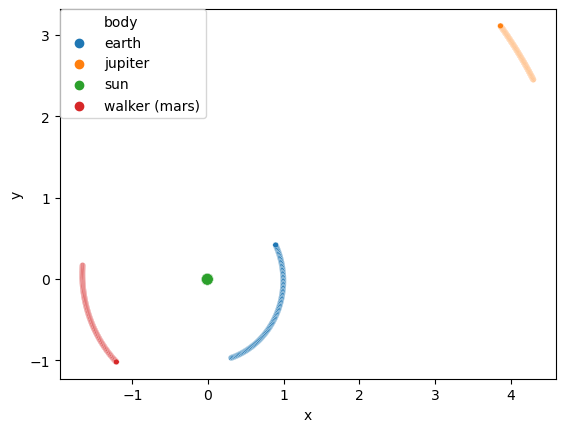

In [7]:
plotter = src.Plotter(walker=walker, system=system)
fig = plotter.draw(mode="2d")

### Testing the `WalkerSystemEnv`

In [8]:
from tf_agents.environments import py_environment, validate_py_environment
from tf_agents.environments import tf_environment, tf_py_environment
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts

In [9]:
walker_name = "mars"
walker_position = src.cartesians_to_array(src.get_cartesian_positions([walker_name], time))
walker_velocity = src.cartesians_to_array(src.get_cartesian_velocities([walker_name], time))

system = src.SunSystem(["earth", "jupiter"])
walker = src.Walker(walker_position, walker_velocity, system, mass=1e-28, name=f"walker ({walker_name})")
solver = src.equations_of_motion_solver_factory("rk4")
target = tf.constant([2., 2., 2.], dtype=tf.float32)

In [10]:
env = src.WalkerSystemEnv(walker, system, solver, target=target)
validate_py_environment(env,  2)

In [11]:
tf_env = tf_py_environment.TFPyEnvironment(env)
print(isinstance(tf_env, tf_environment.TFEnvironment))
print("TimeStep Specs:", tf_env.time_step_spec())
print("Action Specs:", tf_env.action_spec())

True
TimeStep Specs: TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'system-positions': TensorSpec(shape=(3, 3), dtype=tf.float32, name='System Positions'),
                 'target': TensorSpec(shape=(3,), dtype=tf.float32, name='target'),
                 'walker-state': TensorSpec(shape=(6,), dtype=tf.float32, name='Walker Positions')},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})
Action Specs: BoundedTensorSpec(shape=(3,), dtype=tf.float32, name='boost', minimum=array(-1.e-31, dtype=float32), maximum=array(1.e-31, dtype=float32))


In [12]:
from tf_agents.policies import random_tf_policy

time_step_spec = tf_env.time_step_spec()
action_spec    = tf_env.action_spec()

rand_tf_policy = random_tf_policy.RandomTFPolicy(
    time_step_spec=time_step_spec,
    action_spec=action_spec
)

In [13]:
time_step = tf_env._reset()
for _ in range(300):
    action = rand_tf_policy.action(time_step).action
    # action = tf.constant([[0, 0, 0]], dtype=tf.float32)
    time_step = tf_env._step(action) # [action] ?

In [14]:
plotter = src.Plotter(system=system, walker=walker)
plotter.draw("3d")